In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchsummary import summary

from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate


t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
# f = r-a  # free inside reserved

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


10504699904
0
0


In [2]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

# parent_path =  path.home + "/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/" + "data/kp_test_images/"
# parent_path =  path.home + "/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/" + "data/sim_marker/"
parent_path = "/home/jc-merlab/Pictures/Data/"

# root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"
root_dir = parent_path + "occ_panda_physical_og" + "/"

print(root_dir)

/home/jc-merlab/Pictures/Data/occ_panda_physical_og/


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_per_process_memory_fraction(0.9, 0)
print(device)

cuda


In [4]:
# this fucntion tranforms an input image for diverseifying data for training
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

In [5]:
# this function is to split the dataset into train, test and validation folder.
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

#     for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
#         shutil.copy(jsonfile, dst_dir_anno)
        
    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        if not jsonfile.endswith("_vel.json") and not jsonfile.endswith("_combined.json"):
            shutil.copy(jsonfile, dst_dir_anno) 
        
#     output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 

    output = src_dir + "split_folder_output"
    
    print(output)
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output
    

In [6]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
#         self.imgs_files = [file for file in sorted(os.listdir(root)) if file.endswith(".jpg")]
#         self.annotations_files = [file for file in sorted(os.listdir(root)) if file.endswith(".json")]
    
    def __getitem__(self, idx):
#         img_path = os.path.join(self.root, self.imgs_files[idx])
#         annotations_path = os.path.join(self.root, self.annotations_files[idx])
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
#             bboxes_original = data['bboxes'][:3]
            bboxes_original = data['bboxes']
#             print("bounding boxes", bboxes_original)
#             keypoints_original = data['keypoints'][:3]
            keypoints_original = data['keypoints']
#             print("original keypoints", np.array(keypoints_original))
#             print("original keypoints shape", (np.array(keypoints_original)).shape)
            
            # All objects are keypoints on the robot
            bboxes_labels_original = [] 
            bboxes_labels_original.append('base_joint')
            bboxes_labels_original.append('joint2')
            bboxes_labels_original.append('joint3')
            bboxes_labels_original.append('joint4')
            bboxes_labels_original.append('joint5')
            bboxes_labels_original.append('joint6') 
            bboxes_labels_original.append('joint7')
            bboxes_labels_original.append('joint8')
            bboxes_labels_original.append('joint9')
#             bboxes_labels_original.append('panda_finger_1')
#             bboxes_labels_original.append('panda_finger_2')
            
#         print(bboxes_original)
#         print(bboxes_labels_original)

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
#                 print("object", obj)
#                 print(" obj index", o_idx)# Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
#                     print("kp index", k_idx)
#                     print("key points",kp)
#                     print("keypoints original second iter", [keypoints_original[0][o_idx][k_idx]],
#                           [keypoints_original[o_idx][k_idx][0]], [keypoints_original[o_idx][k_idx][1]], \
#                          [keypoints_original[o_idx][k_idx][2]], [keypoints_original[o_idx][k_idx][3]])
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
#             print(keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
#         labels = [1, 2, 3]
        labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]
#         labels = [1, 2, 3, 4, 5, 6, 7, 8]
#         labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]            
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are joint positions
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor(labels, dtype=torch.int64) 
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)
    
    

In [7]:
KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/test" 
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)
# print(batch[2])

# print("Original targets:\n", batch[3], "\n\n")
# print("Transformed targets:\n", batch[1])

/home/jc-merlab/Pictures/Data/occ_panda_physical_og/split_folder_output


Copying files: 24836 files [00:01, 14784.35 files/s]


[[[250, 442]], [[252, 311]], [[241, 253]], [[231, 195]], [[260, 189]], [[319, 143]], [[377, 97]], [[400, 120]], [[372, 149]]]
0
[[250, 442]]
[250, 442]
1
[[252, 311]]
[252, 311]
2
[[241, 253]]
[241, 253]
3
[[231, 195]]
[231, 195]
4
[[260, 189]]
[260, 189]
5
[[319, 143]]
[319, 143]
6
[[377, 97]]
[377, 97]
7
[[400, 120]]
[400, 120]
8
[[372, 149]]
[372, 149]


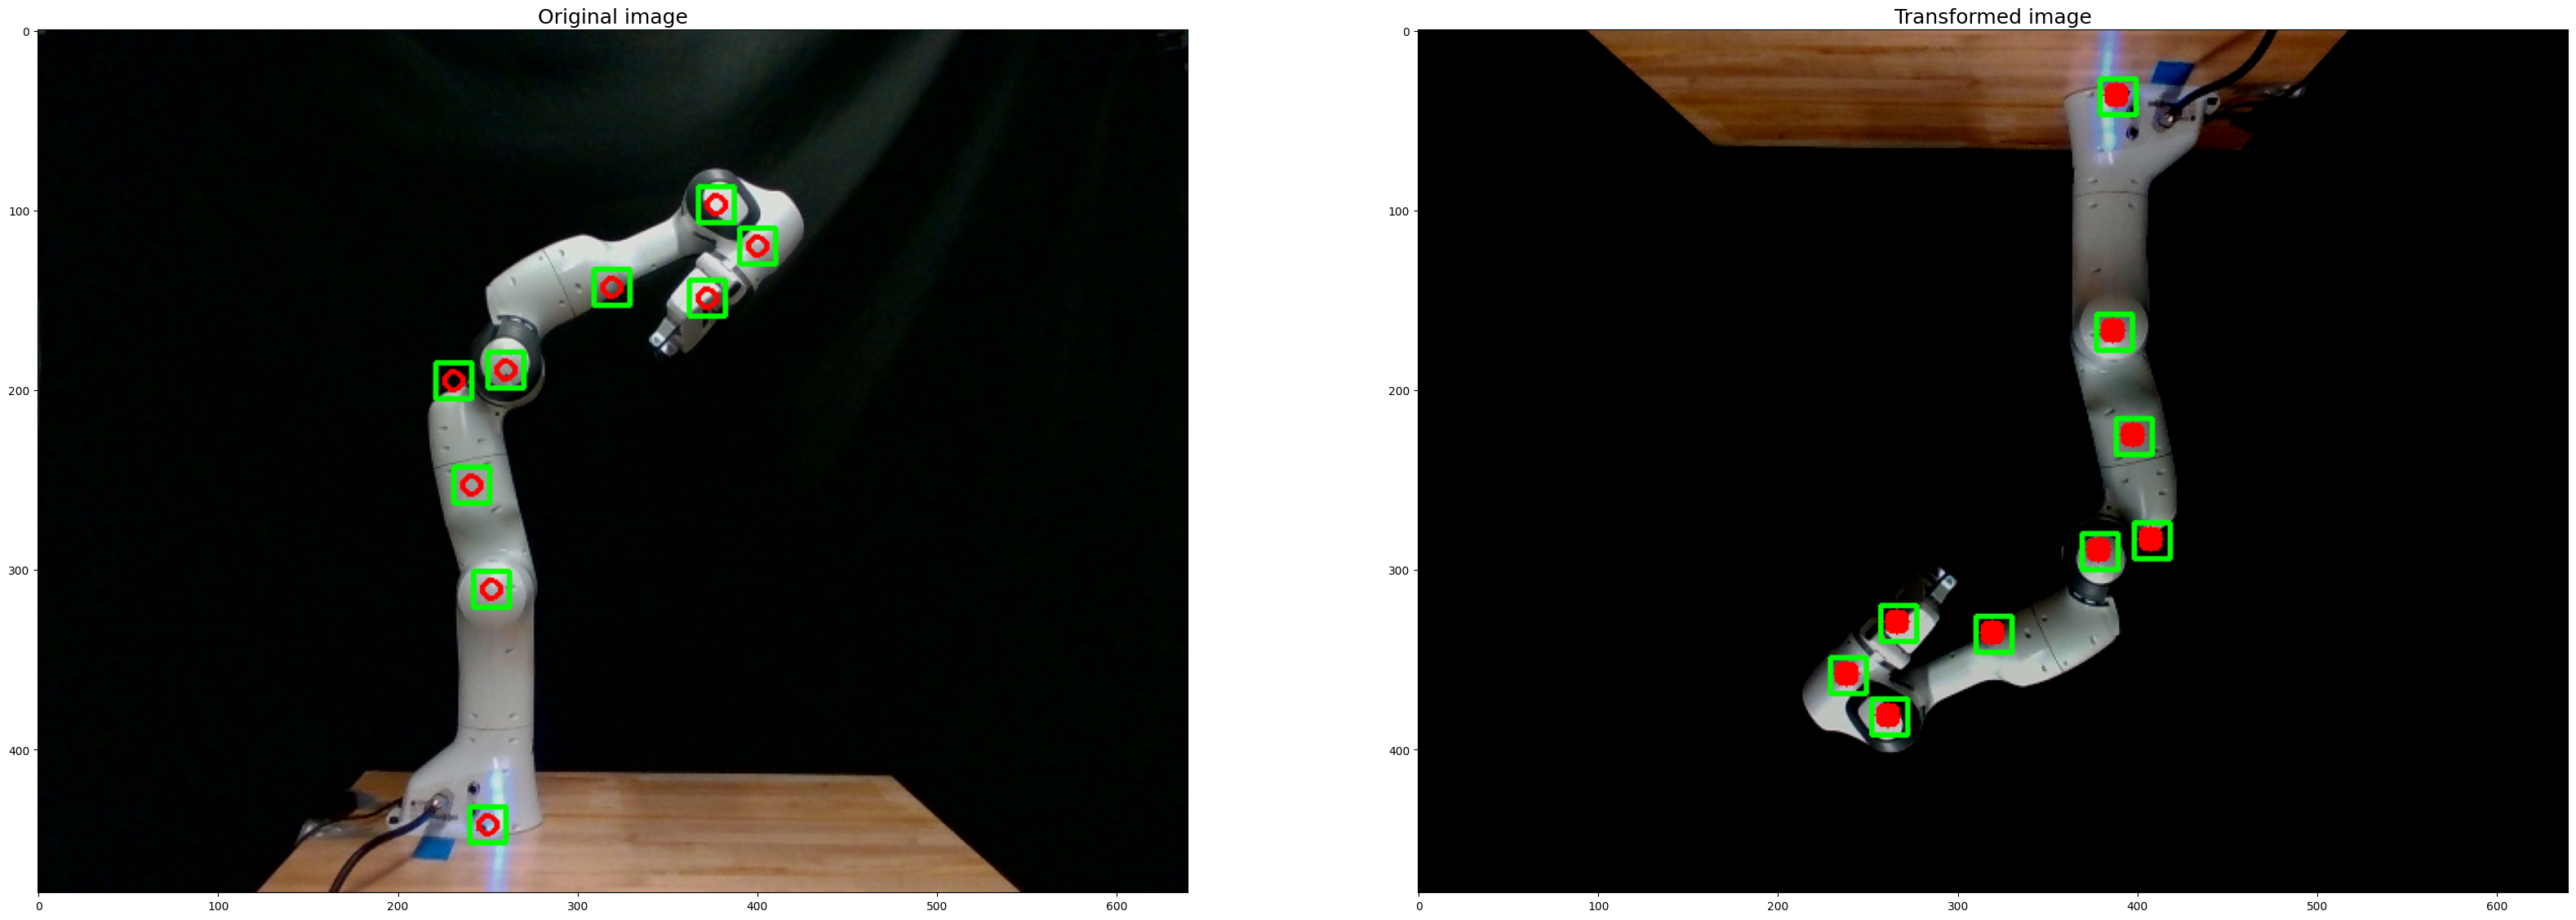

In [8]:
# function to visualize how the transformed data looks 

keypoints_classes_ids2names = {0: 'base_joint', 1: 'joint2', 2: 'joint3', 3: 'joint4', 4: 'joint5', 5: 'joint6',\
                              6:'joint7', 7:'joint8', 8:'joint9'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for idx, kps in enumerate(keypoints):
        for kp in kps:
            image = cv2.circle(image.copy(), tuple(kp), 2, (255,0,0), 10)
#         image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)
        
        return image

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        print(keypoints_original)
        for idx, kps in enumerate(keypoints_original):
            print(idx)
            print(kps)
            for kp in kps:
                print(kp)
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 2)
#             image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
        return None
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
# for kps in batch1[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints.append([kp[:2] for kp in [kps]])
    
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
# for kps in batch1[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints_original.append([kp[:2] for kp in [kps]])
    
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [ ]:
### made changes in the path ../.local/lib/python3.8/site-packages/albumentations/core/bbox_utils.py

'''def normalize_bbox(bbox: TBox, rows: int, cols: int) -> TBox:
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.

    Args:
        bbox: Denormalized bounding box `(x_min, y_min, x_max, y_max)`.
        rows: Image height.
        cols: Image width.

    Returns:
        Normalized bounding box `(x_min, y_min, x_max, y_max)`.

    Raises:
        ValueError: If rows or cols is less or equal zero

    """

    if rows <= 0:
        raise ValueError("Argument rows must be positive integer")
    if cols <= 0:
        raise ValueError("Argument cols must be positive integer")

    tail: Tuple[Any, ...]
    (x_min, y_min, x_max, y_max), tail = bbox[:4], tuple(bbox[4:])
    
    #x_min, x_max = x_min / cols, x_max / cols
    #y_min, y_max = y_min / rows, y_max / rows
    # next lines added by Jani
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(cols - 1, x_max)
    y_max = min(rows - 1, y_max)
    
    return cast(BoxType, (x_min/cols, y_min/rows, x_max/cols, y_max/rows) + tail)  # type: ignore
'''

### made changes in the path ../.local/lib/python3.8/site-packages/albumentations/core/keypoint_utils.py
'''def check_keypoint(kp, rows, cols):
    for name, value, size in zip(["x", "y"], kp[:2], [cols, rows]):
        value = min(max(0.0, value), size - 1)
        kp = tuple([value if i == idx else x for i, x in enumerate(kp)])
        if not 0 <= value < size:
            raise ValueError(
                "Expected {name} for keypoint {kp} "
                "to be in the range [0.0, {size}], got {value}.".format(kp=kp, name=name, value=value, size=size)
            )
    angle = kp[2]
    if not (0 <= angle < 2 * math.pi):
        raise ValueError(
            "Expected angle for keypoint {kp} to be in the range [0.0, 2 * pi], got {angle}.".format(kp=kp, angle=angle)
        )
    return kp

'''

In [10]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights=False,
                                                                   weights_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 10, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [11]:
num_keypoints = 9
model = get_model(num_keypoints, weights_path=None)
model 

/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V2`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [12]:
total_keypoints = 9

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

split_folder_path = train_test_split(root_dir)

KEYPOINTS_FOLDER_TRAIN = split_folder_path +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = split_folder_path +"/val"
KEYPOINTS_FOLDER_TEST = split_folder_path +"/test"

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
# dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=None, demo=False)
dataset_val = ClassDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

# batch_sizes = [3,2]
# epochs_lst = [30,50,100]

# batch_sizes = [3, 2, 1]
# epochs_lst = [25, 30]
batch_sizes = [1]
epochs_lst = [25, 30]

v = 3

for b_size in batch_sizes:
    for epochs in epochs_lst:
        data_loader_train = DataLoader(dataset_train, batch_size=b_size, shuffle=True, collate_fn=collate_fn)
        data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
        data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

        model = get_model(num_keypoints = total_keypoints)
        model.to(device)

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
        num_epochs = epochs

        for epoch in range(num_epochs):
            train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
            lr_scheduler.step()
            
#             if epoch == 25 or epoch == 30 :
#                 PATH = f"/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_ld_b{b_size}_e{epoch}_v{v}.pth"        
#                 torch.save(model, PATH)
#                 v+=1 
            
        
        PATH = f"/home/jc-merlab/Pictures/Data/trained_models/kprcnn_plan_b{b_size}_e{epochs}_v{v}_sim.pth"
            
            
        torch.save(model, PATH)
        
           
        


#     evaluate(model, data_loader_val, device)


/home/jc-merlab/Pictures/Data/occ_panda_physical_og/split_folder_output


Copying files: 24836 files [00:02, 10356.76 files/s]


Epoch: [0]  [   0/8692]  eta: 6:15:17  lr: 0.000002  loss: 11.2282 (11.2282)  loss_classifier: 2.2414 (2.2414)  loss_box_reg: 0.1501 (0.1501)  loss_keypoint: 8.0749 (8.0749)  loss_objectness: 0.6802 (0.6802)  loss_rpn_box_reg: 0.0817 (0.0817)  time: 2.5906  data: 0.0061  max mem: 1320


KeyboardInterrupt: 

In [16]:
import os
import cv2
import torch
import torchvision
import numpy as np
import json
import shutil
from torchvision.transforms import functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_planning_b1_e100_v4.pth'

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_planning_b1_e50_v8.pth'
model = torch.load(weights_path).to(device)
# model = get_model(num_keypoints=6, weights_path=weights_path)
# model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)
model.eval()

# Assuming the necessary imports are done
# Assuming the model is loaded and device is set as in your initial code

# Specify input and output folders
input_folder = '/home/jc-merlab/Pictures/Data/test_data_noopur/'
output_frames_folder = '/home/jc-merlab/Pictures/Data/op_noopur/'

# Check if output folders exist, create them if not
os.makedirs(output_frames_folder, exist_ok=True)

def load_ground_truth(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    # ground_truth_keypoints = [[int(kp[0][0]), int(kp[0][1])] for kp in data['keypoints']]
    ground_truth_keypoints = [[int(kp[0][0]), int(kp[0][1]), kp[0][2]] for kp in data['keypoints']]
    return ground_truth_keypoints

def calculate_accuracy(predicted_keypoints, ground_truth_keypoints, margin=10):
    """
    Calculate the accuracy of predicted keypoints within a margin of 10 pixels.
    Also calculate accuracy for invisible keypoints within a margin of 5 pixels.
    """
    correct = 0
    total = len(ground_truth_keypoints)
    
    correct_invisible = 0
    total_invisible = 0

    for pred_kp, gt_kp in zip(predicted_keypoints, ground_truth_keypoints):
        pred_kp = pred_kp.cpu().numpy()  # Move tensor to CPU and convert to NumPy array
        dist = np.linalg.norm(np.array(pred_kp[:2]) - np.array(gt_kp[:2]))  # Use only x, y for distance calculation
#         print("GT Keypoints", gt_kp)
        if gt_kp[2] == 0:  # Invisible keypoint
            total_invisible += 1
            if dist <= margin:  # Margin for invisible keypoints
                correct_invisible += 1
        else:  # Visible keypoint
            if dist <= margin:
                correct += 1
    
    correct_total = correct + correct_invisible
    accuracy = (correct_total / total) * 100
    invisible_accuracy = (correct_invisible / total_invisible) * 100 if total_invisible > 0 else 0
    return accuracy, invisible_accuracy, total_invisible

# Process images in the folder
accuracies = []
invisible_accuracies = []
total_invisible_keypoints = 0
total_inference_time = []
i = 0
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)

        tensor_image = F.to_tensor(image).to(device)
        tensor_image.unsqueeze_(0)
        tensor_image = list(tensor_image)

        with torch.no_grad():
            output = model(tensor_image)
            tensor_image = (tensor_image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)
        confidence = output[0]['scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()

#         keypoints = []
#         for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             keypoints.append(list(map(int, kps[0,0:2])))
            

            
        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
            
#         bboxes = []
#         for bbox in output[0]['boxes'][high_scores_idxs].detach().cpu().numpy():
#             bboxes.append(list(map(int, bbox.tolist())))
       
#         labels = []
#         for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             labels.append(label)
            
        labels = []
        for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            labels.append(label)
            
        keypoints = []
        for idx, kps in enumerate(output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()):
            keypoints.append(list(map(int, kps[0, 0:2])) + [confidence[idx]] + [labels[idx]])
            
        keypoints = [torch.tensor(kp, dtype=torch.float32).to(device) if not isinstance(kp, torch.Tensor) else kp for kp in keypoints]
        keypoints = torch.stack(keypoints).to(device)
        
        unique_labels, best_keypoint_indices = torch.unique(keypoints[:, 3], return_inverse=True)
        best_scores, best_indices = torch.max(keypoints[:, 2].unsqueeze(0) * (best_keypoint_indices == torch.arange(len(unique_labels)).unsqueeze(1).cuda()), dim=1)
        keypoints = keypoints[best_indices]
            
#         keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]
        # Load ground truth keypoints
        json_filename = filename.split('.')[0] + '.json'  # Construct JSON filename
        json_path = os.path.join(input_folder, json_filename)
        ground_truth_keypoints = load_ground_truth(json_path) 
        
#         print(keypoints)

        # Visualize keypoints on the image
        for point in keypoints:
            x,y, c, l = point
            cv2.circle(image, (int(x), int(y)), 9, (255, 0, 0), -1)  # Draws a blue circle on each keypoint
            
        # Ground truth keypoints in red
        for x, y, _ in ground_truth_keypoints:
            cv2.circle(image, (x, y), radius=5, color=(0, 0, 255), thickness=-1)

        # Save the modified image to the output folder
        output_image_path = os.path.join(output_frames_folder, filename)
        cv2.imwrite(output_image_path, image)
        
        # Calculate and store accuracy
        accuracy, invisible_accuracy, num_invisible = calculate_accuracy(keypoints, ground_truth_keypoints, margin=10)
        accuracies.append(accuracy)
        invisible_accuracies.append(invisible_accuracy)
#         total_inference_time.append(inference_time)
        total_invisible_keypoints += num_invisible
        print(f"Accuracy for {filename}: {accuracy}%")
#         print(f"Invisible Keypoint Accuracy for {filename}: {invisible_accuracy}%")

        i += 1
        
# Print overall accuracy
overall_accuracy = np.mean(accuracies)
overall_invisible_accuracy = np.mean(invisible_accuracies)
avg_inference_time = np.mean(total_inference_time)
print(f"Overall accuracy: {overall_accuracy}%")
# print(f"Overall invisible keypoint accuracy: {overall_invisible_accuracy}%")
# print(f"Total number of invisible keypoints: {total_invisible_keypoints}")
# print(f"Average inference time: {avg_inference_time}")


print("Processing complete!")

cuda
Accuracy for 000011.jpg: 100.0%
Accuracy for 000017.jpg: 100.0%
Accuracy for 000023.jpg: 100.0%
Accuracy for 000025.jpg: 100.0%
Accuracy for 000040.jpg: 100.0%
Accuracy for 000046.jpg: 100.0%
Accuracy for 000049.jpg: 100.0%
Accuracy for 000056.jpg: 100.0%
Accuracy for 000072.jpg: 100.0%
Accuracy for 000084.jpg: 100.0%
Accuracy for 000085.jpg: 100.0%
Accuracy for 000086.jpg: 100.0%
Accuracy for 000100.jpg: 100.0%
Accuracy for 000104.jpg: 100.0%
Accuracy for 000108.jpg: 100.0%
Accuracy for 000110.jpg: 100.0%
Accuracy for 000111.jpg: 100.0%
Accuracy for 000125.jpg: 100.0%
Accuracy for 000126.jpg: 100.0%
Accuracy for 000130.jpg: 100.0%
Accuracy for 000132.jpg: 100.0%
Accuracy for 000133.jpg: 100.0%
Accuracy for 000138.jpg: 100.0%
Accuracy for 000149.jpg: 100.0%
Accuracy for 000151.jpg: 100.0%
Accuracy for 000153.jpg: 100.0%
Accuracy for 000154.jpg: 100.0%
Accuracy for 000157.jpg: 100.0%
Accuracy for 000172.jpg: 100.0%
Accuracy for 000185.jpg: 100.0%
Accuracy for 000187.jpg: 100.0%
Acc

Accuracy for 001380.jpg: 100.0%
Accuracy for 001381.jpg: 100.0%
Accuracy for 001387.jpg: 100.0%
Accuracy for 001388.jpg: 100.0%
Accuracy for 001391.jpg: 100.0%
Accuracy for 001392.jpg: 100.0%
Accuracy for 001398.jpg: 100.0%
Accuracy for 001404.jpg: 100.0%
Accuracy for 001406.jpg: 100.0%
Accuracy for 001412.jpg: 100.0%
Accuracy for 001415.jpg: 100.0%
Accuracy for 001420.jpg: 100.0%
Accuracy for 001421.jpg: 100.0%
Accuracy for 001425.jpg: 100.0%
Accuracy for 001430.jpg: 100.0%
Accuracy for 001437.jpg: 100.0%
Accuracy for 001438.jpg: 100.0%
Accuracy for 001443.jpg: 100.0%
Accuracy for 001463.jpg: 100.0%
Accuracy for 001465.jpg: 100.0%
Accuracy for 001468.jpg: 100.0%
Accuracy for 001475.jpg: 100.0%
Accuracy for 001476.jpg: 100.0%
Accuracy for 001479.jpg: 100.0%
Accuracy for 001481.jpg: 100.0%
Accuracy for 001499.jpg: 100.0%
Accuracy for 001501.jpg: 100.0%
Accuracy for 001502.jpg: 100.0%
Accuracy for 001503.jpg: 100.0%
Accuracy for 001506.jpg: 100.0%
Accuracy for 001514.jpg: 100.0%
Accuracy

Accuracy for 002616.jpg: 100.0%
Accuracy for 002623.jpg: 100.0%
Accuracy for 002626.jpg: 100.0%
Accuracy for 002653.jpg: 100.0%
Accuracy for 002655.jpg: 100.0%
Accuracy for 002658.jpg: 100.0%
Accuracy for 002661.jpg: 100.0%
Accuracy for 002684.jpg: 100.0%
Accuracy for 002688.jpg: 100.0%
Accuracy for 002692.jpg: 100.0%
Accuracy for 002693.jpg: 100.0%
Accuracy for 002695.jpg: 100.0%
Accuracy for 002711.jpg: 100.0%
Accuracy for 002712.jpg: 100.0%
Accuracy for 002719.jpg: 100.0%
Accuracy for 002730.jpg: 100.0%
Accuracy for 002733.jpg: 100.0%
Accuracy for 002734.jpg: 88.88888888888889%
Accuracy for 002735.jpg: 100.0%
Accuracy for 002739.jpg: 100.0%
Accuracy for 002740.jpg: 100.0%
Accuracy for 002752.jpg: 100.0%
Accuracy for 002754.jpg: 100.0%
Accuracy for 002755.jpg: 100.0%
Accuracy for 002756.jpg: 100.0%
Accuracy for 002758.jpg: 100.0%
Accuracy for 002762.jpg: 100.0%
Accuracy for 002773.jpg: 100.0%
Accuracy for 002777.jpg: 100.0%
Accuracy for 002778.jpg: 100.0%
Accuracy for 002785.jpg: 100

Accuracy for 004038.jpg: 100.0%
Accuracy for 004054.jpg: 100.0%
Accuracy for 004055.jpg: 100.0%
Accuracy for 004059.jpg: 100.0%
Accuracy for 004060.jpg: 100.0%
Accuracy for 004064.jpg: 100.0%
Accuracy for 004067.jpg: 100.0%
Accuracy for 004089.jpg: 100.0%
Accuracy for 004090.jpg: 100.0%
Accuracy for 004093.jpg: 100.0%
Accuracy for 004096.jpg: 100.0%
Accuracy for 004097.jpg: 100.0%
Accuracy for 004105.jpg: 100.0%
Accuracy for 004106.jpg: 100.0%
Accuracy for 004123.jpg: 100.0%
Accuracy for 004128.jpg: 100.0%
Accuracy for 004139.jpg: 100.0%
Accuracy for 004150.jpg: 100.0%
Accuracy for 004155.jpg: 100.0%
Accuracy for 004161.jpg: 100.0%
Accuracy for 004169.jpg: 100.0%
Accuracy for 004176.jpg: 100.0%
Accuracy for 004177.jpg: 100.0%
Accuracy for 004179.jpg: 100.0%
Accuracy for 004183.jpg: 100.0%
Accuracy for 004186.jpg: 100.0%
Accuracy for 004193.jpg: 100.0%
Accuracy for 004201.jpg: 100.0%
Accuracy for 004210.jpg: 100.0%
Accuracy for 004215.jpg: 100.0%
Accuracy for 004216.jpg: 100.0%
Accuracy

Accuracy for 005353.jpg: 100.0%
Accuracy for 005362.jpg: 100.0%
Accuracy for 005364.jpg: 100.0%
Accuracy for 005370.jpg: 100.0%
Accuracy for 005372.jpg: 100.0%
Accuracy for 005373.jpg: 100.0%
Accuracy for 005374.jpg: 100.0%
Accuracy for 005375.jpg: 100.0%
Accuracy for 005381.jpg: 100.0%
Accuracy for 005399.jpg: 100.0%
Accuracy for 005400.jpg: 100.0%
Accuracy for 005401.jpg: 100.0%
Accuracy for 005404.jpg: 100.0%
Accuracy for 005411.jpg: 100.0%
Accuracy for 005417.jpg: 100.0%
Accuracy for 005422.jpg: 100.0%
Accuracy for 005427.jpg: 100.0%
Accuracy for 005432.jpg: 100.0%
Accuracy for 005435.jpg: 100.0%
Accuracy for 005438.jpg: 100.0%
Accuracy for 005443.jpg: 100.0%
Accuracy for 005447.jpg: 100.0%
Accuracy for 005455.jpg: 100.0%
Accuracy for 005456.jpg: 100.0%
Accuracy for 005461.jpg: 100.0%
Accuracy for 005482.jpg: 100.0%
Accuracy for 005484.jpg: 100.0%
Accuracy for 005488.jpg: 100.0%
Accuracy for 005489.jpg: 100.0%
Accuracy for 005493.jpg: 100.0%
Accuracy for 005517.jpg: 100.0%
Accuracy

Accuracy for 006590.jpg: 100.0%
Accuracy for 006600.jpg: 100.0%
Accuracy for 006606.jpg: 100.0%
Accuracy for 006626.jpg: 100.0%
Accuracy for 006636.jpg: 100.0%
Accuracy for 006640.jpg: 100.0%
Accuracy for 006642.jpg: 100.0%
Accuracy for 006643.jpg: 100.0%
Accuracy for 006652.jpg: 100.0%
Accuracy for 006655.jpg: 100.0%
Accuracy for 006660.jpg: 100.0%
Accuracy for 006666.jpg: 100.0%
Accuracy for 006685.jpg: 100.0%
Accuracy for 006686.jpg: 100.0%
Accuracy for 006688.jpg: 100.0%
Accuracy for 006689.jpg: 100.0%
Accuracy for 006697.jpg: 100.0%
Accuracy for 006698.jpg: 100.0%
Accuracy for 006703.jpg: 100.0%
Accuracy for 006708.jpg: 100.0%
Accuracy for 006718.jpg: 100.0%
Accuracy for 006723.jpg: 100.0%
Accuracy for 006731.jpg: 100.0%
Accuracy for 006739.jpg: 100.0%
Accuracy for 006743.jpg: 100.0%
Accuracy for 006750.jpg: 100.0%
Accuracy for 006751.jpg: 100.0%
Accuracy for 006756.jpg: 100.0%
Accuracy for 006761.jpg: 100.0%
Accuracy for 006765.jpg: 100.0%
Accuracy for 006767.jpg: 100.0%
Accuracy

Accuracy for 007916.jpg: 100.0%
Accuracy for 007932.jpg: 100.0%
Accuracy for 007940.jpg: 100.0%
Accuracy for 007951.jpg: 100.0%
Accuracy for 007957.jpg: 100.0%
Accuracy for 007967.jpg: 100.0%
Accuracy for 007972.jpg: 100.0%
Accuracy for 007993.jpg: 100.0%
Accuracy for 007996.jpg: 100.0%
Accuracy for 008000.jpg: 100.0%
Accuracy for 008006.jpg: 100.0%
Accuracy for 008008.jpg: 100.0%
Accuracy for 008011.jpg: 100.0%
Accuracy for 008017.jpg: 100.0%
Accuracy for 008019.jpg: 100.0%
Accuracy for 008025.jpg: 100.0%
Accuracy for 008032.jpg: 100.0%
Accuracy for 008037.jpg: 100.0%
Accuracy for 008038.jpg: 100.0%
Accuracy for 008044.jpg: 100.0%
Accuracy for 008047.jpg: 100.0%
Accuracy for 008061.jpg: 100.0%
Accuracy for 008071.jpg: 100.0%
Accuracy for 008079.jpg: 100.0%
Accuracy for 008083.jpg: 100.0%
Accuracy for 008092.jpg: 100.0%
Accuracy for 008094.jpg: 100.0%
Accuracy for 008095.jpg: 100.0%
Accuracy for 008105.jpg: 100.0%
Accuracy for 008108.jpg: 100.0%
Accuracy for 008109.jpg: 100.0%
Accuracy

Accuracy for 009214.jpg: 100.0%
Accuracy for 009216.jpg: 100.0%
Accuracy for 009222.jpg: 100.0%
Accuracy for 009227.jpg: 100.0%
Accuracy for 009232.jpg: 100.0%
Accuracy for 009233.jpg: 100.0%
Accuracy for 009234.jpg: 100.0%
Accuracy for 009236.jpg: 100.0%
Accuracy for 009238.jpg: 100.0%
Accuracy for 009239.jpg: 100.0%
Accuracy for 009243.jpg: 100.0%
Accuracy for 009248.jpg: 100.0%
Accuracy for 009249.jpg: 100.0%
Accuracy for 009250.jpg: 100.0%
Accuracy for 009254.jpg: 100.0%
Accuracy for 009256.jpg: 100.0%
Accuracy for 009270.jpg: 100.0%
Accuracy for 009271.jpg: 100.0%
Accuracy for 009278.jpg: 100.0%
Accuracy for 009280.jpg: 100.0%
Accuracy for 009284.jpg: 100.0%
Accuracy for 009286.jpg: 100.0%
Accuracy for 009293.jpg: 100.0%
Accuracy for 009299.jpg: 100.0%
Accuracy for 009302.jpg: 100.0%
Accuracy for 009305.jpg: 100.0%
Accuracy for 009307.jpg: 100.0%
Accuracy for 009335.jpg: 100.0%
Accuracy for 009341.jpg: 100.0%
Accuracy for 009342.jpg: 100.0%
Accuracy for 009343.jpg: 100.0%
Accuracy

Accuracy for 010442.jpg: 100.0%
Accuracy for 010451.jpg: 100.0%
Accuracy for 010452.jpg: 100.0%
Accuracy for 010457.jpg: 100.0%
Accuracy for 010460.jpg: 100.0%
Accuracy for 010461.jpg: 100.0%
Accuracy for 010477.jpg: 100.0%
Accuracy for 010488.jpg: 100.0%
Accuracy for 010498.jpg: 100.0%
Accuracy for 010503.jpg: 100.0%
Accuracy for 010505.jpg: 100.0%
Accuracy for 010513.jpg: 100.0%
Accuracy for 010529.jpg: 100.0%
Accuracy for 010534.jpg: 100.0%
Accuracy for 010540.jpg: 100.0%
Accuracy for 010542.jpg: 100.0%
Accuracy for 010552.jpg: 100.0%
Accuracy for 010554.jpg: 100.0%
Accuracy for 010560.jpg: 100.0%
Accuracy for 010562.jpg: 100.0%
Accuracy for 010564.jpg: 100.0%
Accuracy for 010574.jpg: 100.0%
Accuracy for 010579.jpg: 100.0%
Accuracy for 010586.jpg: 100.0%
Accuracy for 010589.jpg: 100.0%
Accuracy for 010605.jpg: 100.0%
Accuracy for 010611.jpg: 100.0%
Accuracy for 010615.jpg: 100.0%
Accuracy for 010623.jpg: 100.0%
Accuracy for 010631.jpg: 100.0%
Accuracy for 010637.jpg: 100.0%
Accuracy

Accuracy for 011689.jpg: 100.0%
Accuracy for 011692.jpg: 100.0%
Accuracy for 011693.jpg: 100.0%
Accuracy for 011702.jpg: 100.0%
Accuracy for 011720.jpg: 100.0%
Accuracy for 011726.jpg: 100.0%
Accuracy for 011728.jpg: 100.0%
Accuracy for 011732.jpg: 100.0%
Accuracy for 011735.jpg: 100.0%
Accuracy for 011736.jpg: 100.0%
Accuracy for 011742.jpg: 100.0%
Accuracy for 011749.jpg: 100.0%
Accuracy for 011750.jpg: 100.0%
Accuracy for 011751.jpg: 100.0%
Accuracy for 011758.jpg: 100.0%
Accuracy for 011766.jpg: 100.0%
Accuracy for 011767.jpg: 100.0%
Accuracy for 011772.jpg: 100.0%
Accuracy for 011773.jpg: 100.0%
Accuracy for 011784.jpg: 100.0%
Accuracy for 011786.jpg: 100.0%
Accuracy for 011788.jpg: 100.0%
Accuracy for 011790.jpg: 100.0%
Accuracy for 011804.jpg: 100.0%
Accuracy for 011807.jpg: 100.0%
Accuracy for 011810.jpg: 100.0%
Accuracy for 011818.jpg: 100.0%
Accuracy for 011828.jpg: 100.0%
Accuracy for 011829.jpg: 100.0%
Accuracy for 011831.jpg: 100.0%
Accuracy for 011833.jpg: 100.0%
Accuracy

/home/jc-merlab/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jc-merlab/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
